# Dupire and CEV Equations

Usually you would use market call and put prices and Dupire's equation to estimate local volatility values in a model. This allows us to account for an implied volatility surface.

## CEV Dynamics

The dynamics of the Constanct Elasticity of Variance (CEV) asset prices is as follows:

$$ dS_t = \mu S_t dt + S_t \sigma(S_t,t)dW_t $$

where, 

$ \sigma(S_t, t) = \sigma S_t^{\gamma - 1}$


All other variables are defined as usual in the Black-Scholes model.

#### The Closed-Form Solution to the Value of a Call Option:

$$C(S_0, K, T, \sigma, \gamma) = -S_0 \chi(y;x,x) + K e^{-rT}(1 - \chi(x;z - 2, y))$$

where,

$C(S_0, K, T, \sigma, \gamma)$ is the value of the call on a stock with inistial value $S_0$, strike, K, time to maturity T and $\sigma$ and $\gamma$ as per the CEV volatility terms.


$$\kappa = \frac{2r}{\sigma^2(1-\gamma)e^{2r(1- \gamma)T-1}}$$


$$ x = \kappa S_0^{2(1-\gamma)} e^{2r(1-\gamma)T} $$


$$ y = \kappa K^{2(1-\gamma)} $$


$$ z = 2 + \frac{1}{1-\gamma} $$


and, $\chi(.;d,\lambda)$ is the cdf of a noncentral chi-squared distribution with d degrees of freedom and non-centrality parameter $\lambda$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ncx2

`ncx2.cdf` gets the cdf for noncentral chi-squared distributions

In [2]:
# Variable declaration
S0 = 100
sigma = 0.3
gamma = 0.75
r = 0.1
T = 3

In [12]:
# Call price under CEV Model
z = 2 + 1/(1-gamma)
def call(t,K):
    kappa = 2*r/(sigma**2*(1-gamma)*(np.exp(2*r*(1-gamma)*t)-1))
    x = kappa*S0**(2*(1-gamma))*np.exp(2*r*(1-gamma)*t)
    y = kappa*K**(2*(1-gamma))
    return S0*(1-ncx2.cdf(y,z,x))-K*np.exp(-r*t)*ncx2.cdf(x,z-2,y)

We need to make this a function of time and stock price, since we need to find the first and second derivatives of the function with respect to these two variables.

**Strike Price** we will use strikes that vary between 80 and 120 (incl.)

In [13]:
# Strikes to test volatility
test_strikes = np.linspace(80,120,41)

# Dupire Equation for Local Volatility

Is used to estimate volatility in simulations. The derivation follows the substitution and manipulation of the Fokker-Planck equation and the Breeden-Litzberger equations to the price of a call option:

$$ C(T,K) = e^{-rT}\int_K^{\infty}(x-K)\phi(x,T)dx$$

### 1. Fokker-Planck Equation:

$$ \frac{\partial{\varphi(x,t)}}{\partial{t}} = - \frac{\partial{\mu(x,t)}\varphi(x,t)}{\partial{x}} + \frac{1}{2} \frac{\partial^2 \sigma(x,t)^2 \varphi(x,t)}{\partial{x^2}} $$

### 2. Breeden-Litzenberger Equations:

$$ \frac{\partial}{\partial{K}} C(T,K) = e^{-rT} \int_K^{\infty} - \varphi(x,T) dx $$

$$ \frac{\partial^2}{\partial{K^2}} C(T,K) = e^{-rT}\varphi(K,T) $$

### Computing Local Volatility

We can derive the Fokker-Planck equation and substitute the result with the Breeden-Litzenberger equations to the Call option price:

$$ \frac{\partial}{\partial{T}} C(T,K) = -rK \frac{\partial}{\partial{K}} C(T,K) + \frac{1}{2} \sigma(K,T)^2\frac{\partial^2}{\partial{K^2}} C(T,K) $$

from which we can derive the local volatility $\sigma(K,T)$

**N.B.** It is common to express $\sigma(K,T)$ as $K\bar{\sigma}(K,T)$ which we express in the following equation:

$$ \bar{\sigma}(K,T)  = \frac{\sqrt 2}{K} \sqrt{\frac{\frac{\partial}{\partial{T}}C(T,K) + rK \frac{\partial}{\partial{K}}C(T,K)}{\frac{\partial^2}{\partial{K^2}}C(T,K)}}$$

We need to estimate:

$\frac{\partial}{\partial{T}}C(T,K)$, $\frac{\partial}{\partial{K}}C(T,K)$, $\frac{\partial^2}{\partial{K^2}}C(T,K)$

### Estimating Derivates

We can do so by following the estimates for derivatives:

$$ \frac{\partial}{\partial{a}}f(a,b,c,...) \approx \frac{f(a+\Delta, b, c, ...) - f(a - \Delta, b, c, ...)}{2\Delta} $$

$$ \frac{\partial^2}{\partial{a^2}}f(a,b,c,...) \approx \frac{f(a+2\Delta, b, c, ...) - 2f(a +\Delta, b, c, ...) + f(a,b,c, ...)}{\Delta^2} $$

Where $\Delta$ is some small number. This approximation comes from the definition of a derivative:

$$ \frac{\partial}{\partial{x}}f(x) = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h}$$

In [16]:
# Estimate partial derivatives
delta_t = 0.01
delta_K = 0.01
dC_dT = (call(T+delta_t, test_strikes) - call(T-delta_t, test_strikes))/(2*delta_t)
dC_dK = (call(T, test_strikes + delta_K) - call(T, test_strikes - delta_K))/(2*delta_K)
d2C_dK2 = (call(T, test_strikes+2*delta_K) - 2*call(T, test_strikes + delta_K) + call(T,test_strikes))/(delta_K**2)

#### Estimating Local Volatility under the Dupire Equation:

In [17]:
# estimating local volatility
vol_est = np.sqrt(2)/test_strikes*np.sqrt((dC_dT+r*test_strikes*dC_dK)/d2C_dK2)

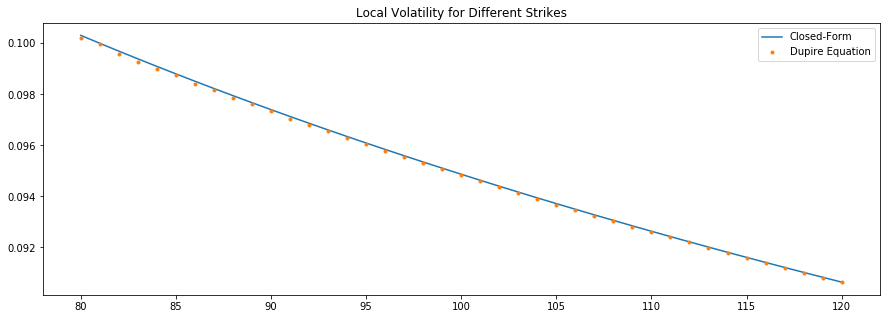

In [38]:
# Plotting the Closed-Form and Dupire Equation
plt.figure(figsize=(15,5))
plt.plot(test_strikes, sigma*test_strikes**(gamma-1), label="Closed-Form")
plt.plot(test_strikes, vol_est, ".", label="Dupire Equation")
plt.title("Local Volatility for Different Strikes")
plt.legend()
plt.show()

### Applications to Put Options

Dupire's equation holds the same for put options:

$$ \bar{\sigma}(K,T)  = \frac{\sqrt 2}{K} \sqrt{\frac{\frac{\partial}{\partial{T}}P(T,K) + rK \frac{\partial}{\partial{K}}P(T,K)}{\frac{\partial^2}{\partial{K^2}}P(T,K)}}$$